In [19]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import collections
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, nonterminal):
        self.buffer.append((state, action, reward, next_state, nonterminal))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, nonterminals = zip(*transitions)
        return states, actions, rewards, next_states, nonterminals
    
    def size(self):
        return len(self.buffer)
    
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.tanh(self.fc2(x))
        return x
    
class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class DDPG:
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, gamma, sigma, tau, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.gamma = gamma
        self.sigma = sigma
        self.tau = tau
        self.device = device

    
    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        action = (action + np.random.randn(self.action_dim)*self.sigma) * self.action_bound
        return action
    
    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data*(1.0-self.tau) + param.data * self.tau)
        
    
    def update(self, states, actions, rewards, next_states, nonterminals):
        states = torch.tensor(states, dtype=torch.float).to(self.device)
        actions = torch.tensor(actions, dtype=torch.float).view(-1,1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float).view(-1,1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float).to(self.device)
        nonterminals = torch.tensor(nonterminals, dtype=torch.float).view(-1,1).to(self.device)

        td_target = rewards + self.gamma * self.target_critic(next_states, self.target_actor(next_states)) * nonterminals
        critic_loss = torch.nn.functional.mse_loss(self.critic(states, actions), td_target).mean()
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        self.soft_update(self.actor, self.target_actor)
        self.soft_update(self.critic, self.target_critic)



actor_lr = 3e-4
critic_lr = 3e-3
hidden_dim = 128
gamma = 0.98
tau = 0.005
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01

device = torch.device("cpu") #torch.device("cuda") if torch.cuda.is_available () else torch.device("cpu")
env_name = "Pendulum-v1"

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]
env.close()
    
def reset_seed():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)

def train(agent, num_episodes):
    reset_seed()
    replay_buffer = ReplayBuffer(buffer_size)
    reward_stat = np.zeros(num_episodes)
    env = gym.make(env_name)
    for episode in range(num_episodes):
        state, info = env.reset(seed=0)
        total_reward = 0
        while True:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            replay_buffer.add(state, action, reward, next_state, not terminated)
            state = next_state
            total_reward += reward
            if replay_buffer.size() > minimal_size:
                states, actions, rewards, next_states, terminateds = replay_buffer.sample(batch_size)
                agent.update(states, actions, rewards, next_states, terminateds)
            if terminated or truncated:
                break
        if episode*10 % num_episodes == 0:
            print("episode:", episode, "total_reward:",total_reward)
        reward_stat[episode] = total_reward
    env.close()
    return reward_stat

def test(agent, num_episodes):
    env = gym.make(env_name,render_mode="human")
    for episode in range(num_episodes):
        state, info = env.reset()
        total_reward = 0
        while True:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            state = next_state
            total_reward += reward
            if terminated or truncated:
                break
        #print("episode:", episode, "total_reward:",total_reward)
    env.close()


def moving_average(nums, n):
    beta = 1 - 1.0/n
    alpha = 1.0 - beta
    avg = nums[0]
    res = np.zeros_like(nums)
    for n in range(len(nums)):
        avg = avg * beta + nums[n]*alpha
        res[n] = avg
    return res

episode: 0 total_reward: -1263.655144839394
episode: 10 total_reward: -1618.779662740694
episode: 20 total_reward: -1372.5322757504948
episode: 30 total_reward: -596.6585740800544
episode: 40 total_reward: -126.20686193644505
episode: 50 total_reward: -125.93357353114271
episode: 60 total_reward: -125.60980272104686
episode: 70 total_reward: -125.86168373091532
episode: 80 total_reward: -128.44263953527943
episode: 90 total_reward: -126.42208882576449


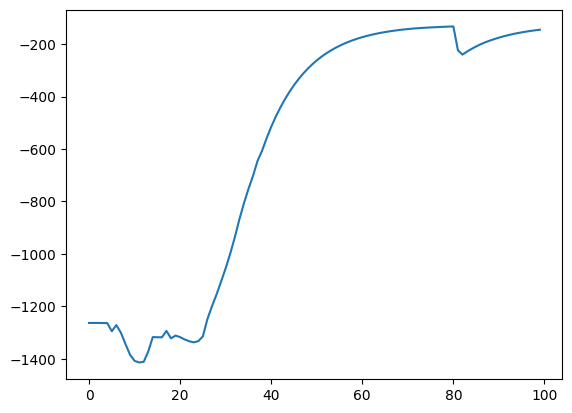

In [25]:
num_episodes = 100
reset_seed()
agent1 = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, gamma, sigma, tau, device)
reward_stat1  = train(agent1, num_episodes)
plt.plot(range(len(reward_stat1)), moving_average(reward_stat1,10))
plt.show()


In [23]:
test(agent1,1)